# Homework: Compare Two Logistic Regression Models (Weather & Climate)

**Compare the performance of two logistic regression models**  
- **Model A (Full):** `CAPE`, `PWAT`, `Shear`  
- **Model B (Reduced):** `CAPE`, only

Does the three parameter model work better than the one parameter model?

**Tasks**
1. Split data into train/test.
2. Fit both models.
3. Compute **accuracy**, **precision**, **recall** at threshold 0.5.
4. Plot **ROC** and **Precision–Recall** curves for both models on the same figures.
5. Answer the interpretation questions.


In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             RocCurveDisplay, PrecisionRecallDisplay)

FEATURES_FULL = ['cape','pwat','shear']
FEATURES_REDUCED = ['cape']
TARGET = 'event'

# Synthetic fallback
USE_SYNTHETIC = True

if USE_SYNTHETIC:
    rng = np.random.default_rng(42)
    n = 1200
    cape  = rng.gamma(5.0, 250.0, size=n)
    pwat  = rng.normal(30, 8, size=n).clip(5, 70)
    shear = rng.normal(15, 6, size=n).clip(0, 40)
    z = -6.0 + 0.0025*cape + 0.06*pwat + 0.05*shear + 0.00002*cape*shear
    p = 1/(1+np.exp(-z))
    y = rng.binomial(1, p)
    df = pd.DataFrame({'cape':cape, 'pwat':pwat, 'shear':shear, 'event':y})
else:
    df = pd.read_csv('../data/your_data.csv').dropna()
    assert TARGET in df.columns
    assert all(c in df.columns for c in FEATURES_FULL)
    df = df[FEATURES_FULL + [TARGET]]
df.head()

,cape,pwat,shear,event
0,1339.091679,24.846334,4.350342,1
1,1620.699558,34.709626,23.376549,1
2,1237.079261,26.431445,20.809474,1
3,1157.616507,37.841527,29.506833,1
4,1708.955858,32.249385,6.662860,1


## 1) Train/Test Split

In [2]:
# TODO: Split into train/test for both feature sets using SAME random_state and stratify by y
X_full = df[FEATURES_FULL].values
X_reduced = df[FEATURES_REDUCED].values
y = df[TARGET].values.astype(int)

# YOUR CODE HERE
Xf_train, Xf_test, yf_train, yf_test = train_test_split(X_full, y, test_size=0.25, random_state=0, stratify=y)
Xr_train, Xr_test, yr_train, yr_test = train_test_split(X_reduced, y, test_size=0.25, random_state=0, stratify=y)

len(Xf_train), len(Xf_test)

(900, 300)

In [7]:
#Check for reduced
len(Xr_train), len(Xr_test)


(900, 300)

## 2) Fit Both Logistic Regression Models

In [8]:
# TODO: Fit two LogisticRegression models (full and reduced). Use max_iter >= 200.
# YOUR CODE HERE
clf_full = LogisticRegression(max_iter=200).fit(Xf_train, yf_train)
clf_reduced = LogisticRegression(max_iter=200).fit(Xr_train, yr_train)

yprob_full = clf_full.predict_proba(Xf_test)[:,1]
yprob_reduced = clf_reduced.predict_proba(Xr_test)[:,1]

clf_full.coef_, clf_reduced.coef_

(array([[0.00294362, 0.0514564 , 0.0928135 ]]), array([[0.00269818]]))

## 3) Metrics at Threshold 0.5

In [9]:
thr = 0.5
ypred_full = (yprob_full >= thr).astype(int)
ypred_reduced = (yprob_reduced >= thr).astype(int)

# TODO: Compute Accuracy, Precision, Recall for both models at threshold 0.5

In [10]:
#The accuracy_score function computes the accuracy, either the fraction (default) or the count (normalize=False) of correct predictions.

#Intuitively, precision is the ability of the classifier not to label as positive a sample that is negative, and recall is the ability of the classifier to find all the positive samples.

acc_full = accuracy_score(yf_test, ypred_full)
prec_full = precision_score(yf_test, ypred_full, zero_division=0)
rec_full = recall_score(yf_test, ypred_full, zero_division=0)


In [11]:
acc_reduced = accuracy_score(yr_test, ypred_reduced)
prec_reduced = precision_score(yr_test, ypred_reduced, zero_division=0)
rec_reduced = recall_score(yr_test, ypred_reduced, zero_division=0)

In [12]:
#Put results into a DataFrame for easy viewing

results = pd.DataFrame({
'model': ['full', 'reduced'],
'accuracy': [acc_full, acc_reduced],
'precision': [prec_full, prec_reduced],
'recall': [rec_full, rec_reduced]
}).set_index('model')

print(results.round(3))

         accuracy  precision  recall
model                               
full        0.723      0.733   0.678
reduced     0.717      0.736   0.651


## 4) Plot ROC and Precision–Recall Curves

ROC AUC - full: 0.812, reduced: 0.791
PR  AUC - full: 0.818, reduced: 0.798


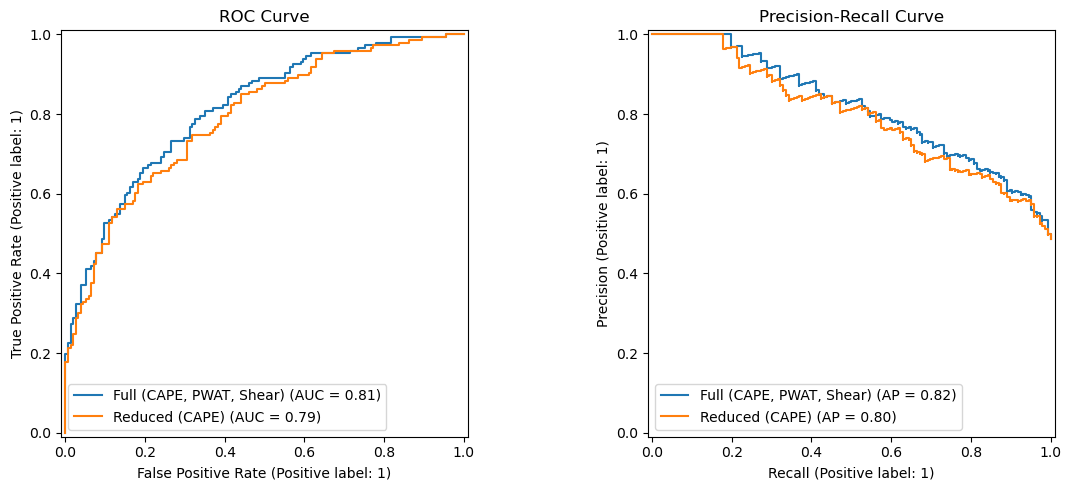

In [ ]:
# Plot ROC and PR curves for both models on shared axes
from sklearn.metrics import roc_auc_score, average_precision_score

# Compute numeric AUCs
#In the case where the main interest is not the plot but the ROC-AUC score itself, we can reproduce the value shown in the plot using roc_auc_score.
roc_auc_full = roc_auc_score(yf_test, yprob_full)
roc_auc_reduced = roc_auc_score(yr_test, yprob_reduced)
pr_auc_full = average_precision_score(yf_test, yprob_full)
pr_auc_reduced = average_precision_score(yr_test, yprob_reduced)

print(f"ROC AUC - full: {roc_auc_full:.3f}, reduced: {roc_auc_reduced:.3f}")
print(f"PR  AUC - full: {pr_auc_full:.3f}, reduced: {pr_auc_reduced:.3f}")

fig, axes = plt.subplots(1, 2, figsize=(12,5))

# ROC on left
RocCurveDisplay.from_predictions(yf_test, yprob_full, name='Full (CAPE, PWAT, Shear)', ax=axes[0])
RocCurveDisplay.from_predictions(yr_test, yprob_reduced, name='Reduced (CAPE)', ax=axes[0])
axes[0].set_title('ROC Curve')
axes[0].legend()

# Precision-Recall on right
PrecisionRecallDisplay.from_predictions(yf_test, yprob_full, name='Full (CAPE, PWAT, Shear)', ax=axes[1])
PrecisionRecallDisplay.from_predictions(yr_test, yprob_reduced, name='Reduced (CAPE)', ax=axes[1])
axes[1].set_title('Precision-Recall Curve')
axes[1].legend()

plt.tight_layout()


## 5) Interpretation

1. Which model has higher **ROC-AUC** and **PR-AUC**? What does this imply about `PWAT`?  
2. Compare **accuracy**, **precision**, and **recall** for both models.  
   - Which model would you choose to **maximize event detection** (recall)?  
   - Which model would you choose to **minimize false alarms** (precision)?  

 From the scikit-Learn documentation. 
 Precision is a measure of the fraction of relevant items among actually returned items while recall is a measure of the fraction of items that were returned among all items that should have been returned.
 The precision-recall curve shows the tradeoff between precision and recall for different thresholds. A high area under the curve represents both high recall and high precision. High precision is achieved by having few false positives in the returned results, and high recall is achieved by having few false negatives in the relevant results. High scores for both show that the classifier is returning accurate results (high precision), as well as returning a majority of all relevant results (high recall).

The Receiver Operating Characteristic (ROC) curves typically feature true positive rate (TPR) on the Y axis, and false positive rate (FPR) on the X axis. This means that the top left corner of the plot is the “ideal” point - a FPR of zero, and a TPR of one. This is not very realistic, but it does mean that a larger area under the curve (AUC) is usually better. The “steepness” of ROC curves is also important, since it is ideal to maximize the TPR while minimizing the FPR.

Answers: 
1) The Full Model has higher ROC-AUC and  that means that having more features improves the clasification of the event. This implies that using precipitable water improves the model. 

2) The full model has better accuracy and recall, while the reduced model has slightly better precision. The values are considerable similar so the recommendation is dificult, but I will select the full model to maximize detection and the reduced model to minimize false alarms based on the decimal values differences. 
